In [1]:
# ==============================================================================
# STEP 0: ENVIRONMENT SETUP
# ==============================================================================

# --- 1. Mount Google Drive ---
# This command connects your Colab notebook to your Google Drive.
# You will be prompted to authorize the connection.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# --- 2. Install necessary libraries (if not already installed) ---
!pip install xgboost shap -q

print("Setup complete. You can now proceed with Step 1.")

Mounted at /content/drive
Google Drive mounted successfully!
Setup complete. You can now proceed with Step 1.


In [2]:
# ==============================================================================
# MIMIC-IV DEMO - STEP 1: LOAD, FILTER, AND RESHAPE DATA
# ==============================================================================
import pandas as pd
import numpy as np
import os
import gc

# --- 1. Define file paths ---
base_path = '/content/drive/MyDrive/mimic-iv-demo'
icu_path = os.path.join(base_path, 'icu')

# --- 2. Load the necessary source files ---
try:
    d_items_path = os.path.join(icu_path, 'd_items.csv.gz')
    df_items = pd.read_csv(d_items_path)
    print("d_items.csv.gz loaded successfully.")

    chartevents_path = os.path.join(icu_path, 'chartevents.csv.gz')
    df_chartevents = pd.read_csv(chartevents_path, low_memory=False)
    print("chartevents.csv.gz loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: File not found. Please check your path: {e.filename}")
    df_items = None
    df_chartevents = None

# --- 3. Define the selected ITEMIDs for our vital signs ---
# These are the IDs we identified in the previous exploration step.
# We will use the continuous Arterial Blood Pressure measurements.
if 'df_chartevents' in locals() and df_chartevents is not None:
    selected_ids = {
        'Heart_Rate': 220045,
        'SpO2': 220277,
        'Arterial_BP_Systolic': 220050,
        'Arterial_BP_Diastolic': 220051,
        'Arterial_BP_Mean': 220052,
        'Respiratory_Rate': 220210,
        'Temperature_C': 223762
    }

    id_list = list(selected_ids.values())

    # --- 4. Filter the massive chartevents dataframe ---
    print(f"\nOriginal chartevents size: {len(df_chartevents)} rows")
    df_vitals = df_chartevents[df_chartevents['itemid'].isin(id_list)].copy()
    print(f"Filtered down to {len(df_vitals)} rows containing our selected vital signs.")

    # --- 5. Pivot the data from 'long' to 'wide' format ---
    print("\nPivoting data to a time-series format (wide)...")

    # Create a mapping from itemid back to a clean label name for the new columns
    id_to_label = {v: k for k, v in selected_ids.items()}
    df_vitals['label'] = df_vitals['itemid'].map(id_to_label)

    # Pivot the table to get one row per timestamp, with vitals as columns
    # We also select only the necessary columns before pivoting for efficiency
    df_wide = df_vitals[['subject_id', 'charttime', 'label', 'valuenum']].pivot_table(
        index=['subject_id', 'charttime'],
        columns='label',
        values='valuenum'
    ).reset_index()

    print("Pivoting complete.")

    # --- 6. Clean up memory ---
    del df_chartevents
    del df_items
    del df_vitals
    gc.collect()
    print("Intermediate dataframes removed from memory.")

    # --- 7. Display final result ---
    print("\n--- First 5 rows of the new 'wide' format dataframe ---")
    display(df_wide.head())

    print("\n--- Info on the final wide dataframe ---")
    display(df_wide.info())

else:
    print("\nERROR: Could not proceed because base files were not loaded.")

d_items.csv.gz loaded successfully.
chartevents.csv.gz loaded successfully.

Original chartevents size: 668862 rows
Filtered down to 58366 rows containing our selected vital signs.

Pivoting data to a time-series format (wide)...
Pivoting complete.
Intermediate dataframes removed from memory.

--- First 5 rows of the new 'wide' format dataframe ---


label,subject_id,charttime,Arterial_BP_Diastolic,Arterial_BP_Mean,Arterial_BP_Systolic,Heart_Rate,Respiratory_Rate,SpO2,Temperature_C
0,10000032,2180-07-23 14:12:00,NaN,NaN,NaN,91.0,24.0,NaN,NaN
1,10000032,2180-07-23 14:13:00,NaN,NaN,NaN,NaN,NaN,98.0,NaN
2,10000032,2180-07-23 14:30:00,NaN,NaN,NaN,93.0,21.0,97.0,NaN
3,10000032,2180-07-23 15:00:00,NaN,NaN,NaN,94.0,23.0,97.0,NaN
4,10000032,2180-07-23 16:00:00,NaN,NaN,NaN,105.0,21.0,94.0,NaN



--- Info on the final wide dataframe ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15471 entries, 0 to 15470
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             15471 non-null  int64  
 1   charttime              15471 non-null  object 
 2   Arterial_BP_Diastolic  5524 non-null   float64
 3   Arterial_BP_Mean       5560 non-null   float64
 4   Arterial_BP_Systolic   5525 non-null   float64
 5   Heart_Rate             13913 non-null  float64
 6   Respiratory_Rate       13913 non-null  float64
 7   SpO2                   13540 non-null  float64
 8   Temperature_C          391 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.1+ MB


None

In [3]:
# ==============================================================================
# MIMIC-IV DEMO - STEP 2: TIME-SERIES PREPROCESSING AND IMPUTATION
# ==============================================================================
from sklearn.preprocessing import StandardScaler

if 'df_wide' in locals():
    print("--- Starting time-series preprocessing ---")

    # 1. Convert 'charttime' column to datetime objects
    df_wide['charttime'] = pd.to_datetime(df_wide['charttime'])
    print("-> Converted 'charttime' to datetime objects.")

    # 2. Resample and impute data for each patient
    # We will process each patient individually to not mix their data
    processed_patients = []

    # Use .groupby() to iterate over each patient's data
    for patient_id, group in df_wide.groupby('subject_id'):
        # Set the time column as the index for time-based operations
        group = group.set_index('charttime').drop('subject_id', axis=1)

        # Resample to a fixed frequency (e.g., every 15 minutes) and take the mean
        # This creates a uniform timeline for all patients
        group_resampled = group.resample('15T').mean()

        # Impute missing values using forward-fill, then backward-fill
        group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')

        # Add the patient_id back
        group_imputed['subject_id'] = patient_id

        processed_patients.append(group_imputed)

    # Concatenate all processed patient dataframes back into one
    df_processed = pd.concat(processed_patients).reset_index()
    print("-> Resampled to a 15-minute frequency and imputed missing values.")

    # 3. Handle any fully-NaN patients that might remain and scale features
    df_processed.dropna(inplace=True) # Drop patients with no measurements at all

    vital_cols = [col for col in df_processed.columns if col not in ['subject_id', 'charttime']]

    scaler = StandardScaler()
    df_processed[vital_cols] = scaler.fit_transform(df_processed[vital_cols])
    print("-> Scaled vital sign features.")

    # 4. Display final result
    print("\n--- Preprocessing complete. Data is now clean and uniform. ---")
    display(df_processed.info())
    display(df_processed.head())

else:
    print("ERROR: Wide-format dataframe 'df_wide' not found. Please run Step 1 successfully.")

--- Starting time-series preprocessing ---
-> Converted 'charttime' to datetime objects.


/tmp/ipython-input-3-992980437.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-3-992980437.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-3-992980437.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_resampled = group.resample('15T').mean()
/tmp/ipython-input-3-992980437.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group_imputed = group_resampled.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-3-992980437.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please

-> Resampled to a 15-minute frequency and imputed missing values.
-> Scaled vital sign features.

--- Preprocessing complete. Data is now clean and uniform. ---
<class 'pandas.core.frame.DataFrame'>
Index: 87355 entries, 98496 to 933440
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   charttime              87355 non-null  datetime64[ns]
 1   Arterial_BP_Diastolic  87355 non-null  float64       
 2   Arterial_BP_Mean       87355 non-null  float64       
 3   Arterial_BP_Systolic   87355 non-null  float64       
 4   Heart_Rate             87355 non-null  float64       
 5   Respiratory_Rate       87355 non-null  float64       
 6   SpO2                   87355 non-null  float64       
 7   Temperature_C          87355 non-null  float64       
 8   subject_id             87355 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 6.7 MB


None

label,charttime,Arterial_BP_Diastolic,Arterial_BP_Mean,Arterial_BP_Systolic,Heart_Rate,Respiratory_Rate,SpO2,Temperature_C,subject_id
98496,2130-10-27 16:30:00,1.586719,0.022509,-0.658884,-0.012545,-4.005787,2.707452,-0.789017,10005348
98497,2130-10-27 16:45:00,0.893515,-0.386087,-5.504051,-0.012545,-3.575373,2.707452,-0.789017,10005348
98498,2130-10-27 17:00:00,0.546913,-0.492020,-6.739094,-0.012545,-3.575373,2.707452,-0.862301,10005348
98499,2130-10-27 17:15:00,0.893515,-0.340688,-5.219041,-0.012545,-3.575373,2.707452,-0.953906,10005348
98500,2130-10-27 17:30:00,1.471185,-0.128823,-2.748956,-0.012545,-1.853719,2.707452,-0.807338,10005348


In [4]:
# ==============================================================================
# SAVE THE PROCESSED DATAFRAME (Corrected Variable Name)
# ==============================================================================

# The variable created by our last preprocessing script is 'df_processed'
if 'df_processed' in locals():
    # Define the path where the file will be saved
    save_path = '/content/drive/MyDrive/mimic-iv-demo/df_processed_final.parquet'

    # Save the dataframe to a Parquet file
    print(f"Saving the processed dataframe ('df_processed') to {save_path}...")
    df_processed.to_parquet(save_path)
    print("Save complete!")
else:
    print("ERROR: Dataframe 'df_processed' not found. Please ensure the preprocessing cell has been run successfully.")

Saving the processed dataframe ('df_processed') to /content/drive/MyDrive/mimic-iv-demo/df_processed_final.parquet...
Save complete!


--- Preparing data for Autoencoder ---
Created 87331 sequences of shape (24, 7)
Training data shape: (69864, 24, 7)
Test data shape: (17467, 24, 7)

--- Building LSTM Autoencoder Model ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 7)          │           455 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,911 (202.78 KB)

 Trainable params: 51,911 (202.78 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Autoencoder on normal patterns ---
Epoch 1/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.1455 - val_loss: 0.0666
Epoch 2/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0642 - val_loss: 0.0598
Epoch 3/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0608 - val_loss: 0.0569
Epoch 4/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0584 - val_loss: 0.0562
Epoch 5/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 6/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0543 - val_loss: 0.0514
Epoch 7/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0523 - val_loss: 0.0502
Epoch 8/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0506 - val_loss: 0.0471
Epoch 9/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0480 - val_loss: 0.0456
Epoch 10/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0463 - val_loss: 0.0454

--- Detecting anomalies based on reconstruction error ---
546/546 ━━━━━━━━━━━━━━━━━━━━ 

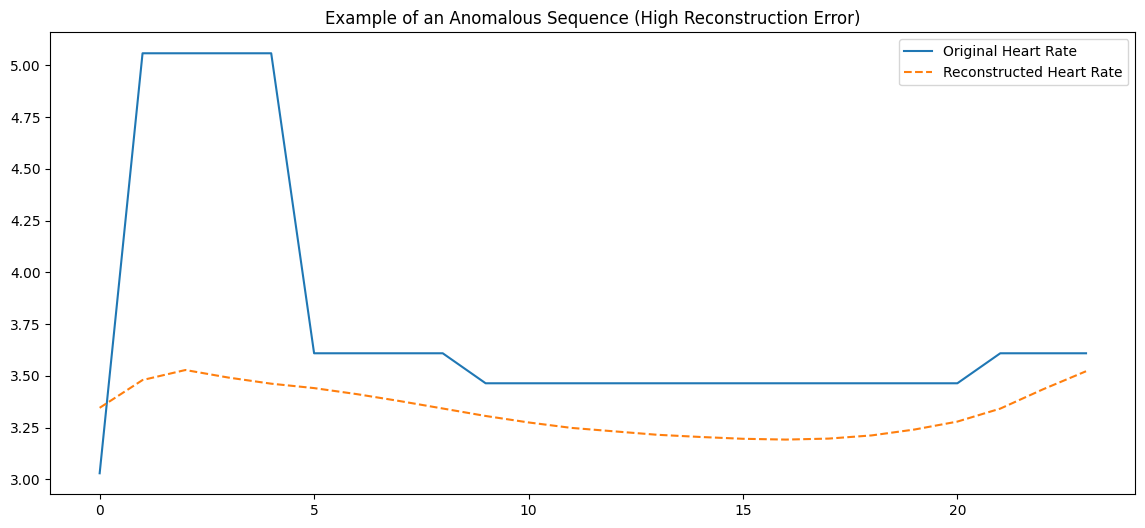

In [5]:
# ==============================================================================
# MIMIC-IV DEMO - STEP 3: UNSUPERVISED ANOMALY DETECTION WITH LSTM AUTOENCODER
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper Function to create time-series sequences ---
def create_sequences(X_data, y_data, time_steps=10):
    """Creates time-series sequences from 2D data."""
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        v = X_data[i:(i + time_steps)]
        Xs.append(v)
        # The y_data is just a placeholder here, not used for training
        ys.append(y_data[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

# --- Main Logic ---
if 'df_processed' in locals():
    # 1. Prepare Data for the Autoencoder
    print("--- Preparing data for Autoencoder ---")

    # Select only the vital sign columns for training
    vital_cols = ['Arterial_BP_Diastolic', 'Arterial_BP_Mean', 'Arterial_BP_Systolic',
                  'Heart_Rate', 'Respiratory_Rate', 'SpO2', 'Temperature_C']
    data_for_model = df_processed[vital_cols].values

    # Create sequences. We don't need the 'y' labels for autoencoder training.
    TIME_STEPS = 24 # Using a window of 24 samples (e.g., 6 hours if data is every 15 mins)
    X_sequences, _ = create_sequences(data_for_model, data_for_model[:, 0], time_steps=TIME_STEPS)
    print(f"Created {X_sequences.shape[0]} sequences of shape {X_sequences.shape[1:]}")

    # Split into training and testing sets. We will test the model's ability to reconstruct unseen data.
    X_train, X_test = train_test_split(X_sequences, test_size=0.2, random_state=42)
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    # 2. Build the LSTM Autoencoder Model
    n_features = X_train.shape[2]
    timesteps = X_train.shape[1]

    print("\n--- Building LSTM Autoencoder Model ---")
    inputs = Input(shape=(timesteps, n_features))
    # Encoder
    encoded = LSTM(64, activation='relu')(inputs)
    # Bottleneck
    bottleneck = RepeatVector(timesteps)(encoded)
    # Decoder
    decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)
    # Output Layer
    outputs = TimeDistributed(Dense(n_features))(decoded)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae') # Using Mean Absolute Error as the loss function
    autoencoder.summary()

    # 3. Train the Autoencoder
    print("\n--- Training Autoencoder on normal patterns ---")
    history = autoencoder.fit(
        X_train, X_train, # The model learns to predict its own input
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=1
    )

    # 4. Detect Anomalies based on Reconstruction Error
    print("\n--- Detecting anomalies based on reconstruction error ---")
    # Calculate the reconstruction error on the test set
    X_test_pred = autoencoder.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Choose a threshold for anomalies (e.g., the 95th percentile of the error)
    threshold = np.quantile(test_mae_loss, 0.95)
    print(f"Reconstruction error threshold for anomalies set to: {threshold:.3f}")

    # Identify the indices of the anomalies
    anomaly_indices = np.where(test_mae_loss.mean(axis=1) > threshold)[0] # axis=1 to average error across features
    print(f"Found {len(anomaly_indices)} potential anomalies in the test set.")

    # 5. Visualize a detected anomaly
    if len(anomaly_indices) > 0:
        print("\n--- Visualizing a detected anomaly ---")
        idx_to_plot = anomaly_indices[0]

        plt.figure(figsize=(14, 6))
        # Plot the original signal (e.g., Heart Rate, which is column index 3 in vital_cols)
        plt.plot(X_test[idx_to_plot, :, 3], label='Original Heart Rate')
        # Plot the reconstructed signal
        plt.plot(X_test_pred[idx_to_plot, :, 3], label='Reconstructed Heart Rate', linestyle='--')
        plt.title('Example of an Anomalous Sequence (High Reconstruction Error)')
        plt.legend()
        plt.show()

else:
    print("ERROR: Processed dataframe 'df_processed' not found. Please run the preprocessing steps first.")

--- Analyzing the results of the LSTM Autoencoder ---
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


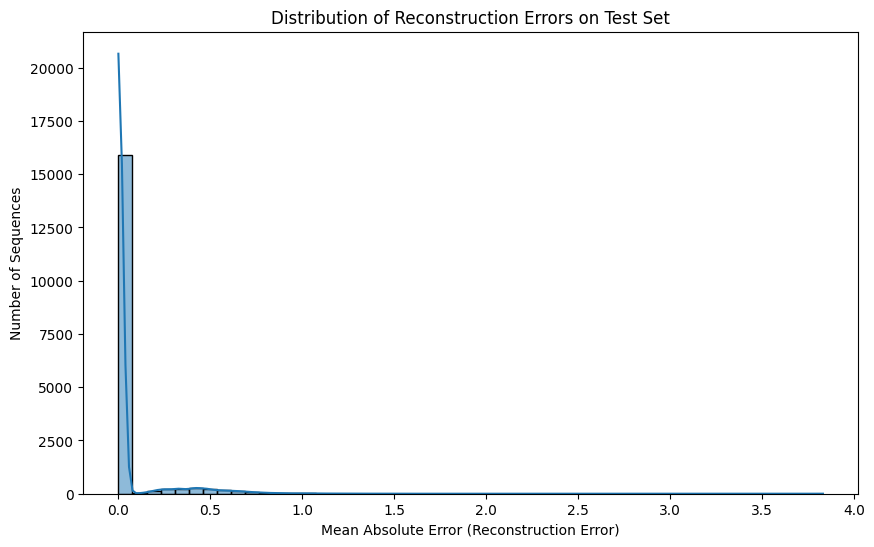


Reconstruction error threshold for anomalies set to: 0.4130 (95th percentile)
Found 874 potential anomalies in the test set (5.00% of test data).

--- Visualizing a top detected anomaly ---


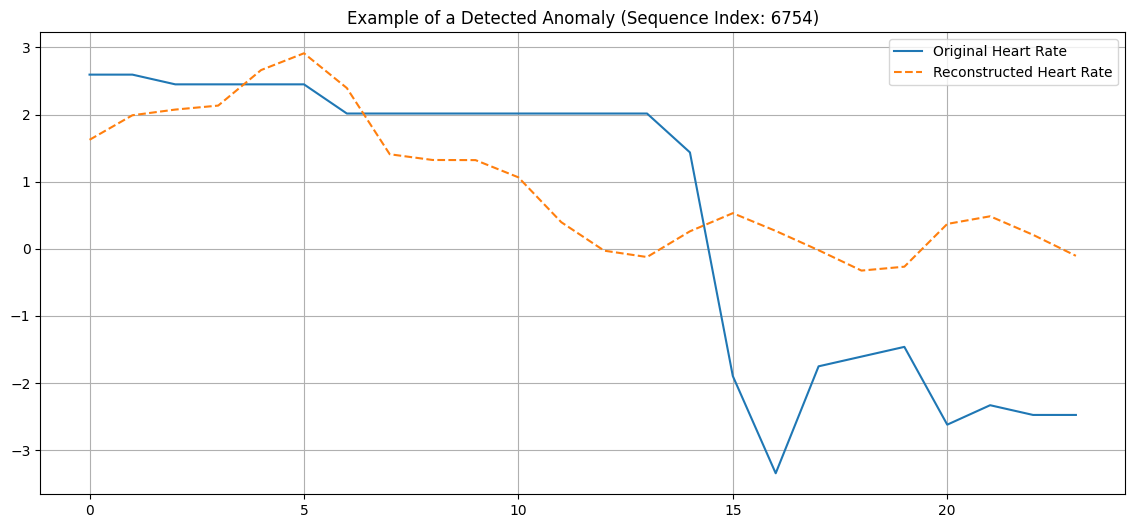

In [6]:
# ==============================================================================
# MIMIC-IV DEMO - STEP 4: ANALYSIS OF DETECTED ANOMALIES
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #

# Check if the results from the autoencoder training cell exist
if 'autoencoder' in locals() and 'X_test' in locals():
    print("--- Analyzing the results of the LSTM Autoencoder ---")

    # 1. Recalculate reconstruction error on the test set
    X_test_pred = autoencoder.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # 2. Plot the distribution of reconstruction errors
    plt.figure(figsize=(10, 6))
    sns.histplot(test_mae_loss.mean(axis=1), bins=50, kde=True)
    plt.xlabel("Mean Absolute Error (Reconstruction Error)")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Reconstruction Errors on Test Set")
    plt.show()

    # 3. Define a threshold and identify anomalies
    threshold = np.quantile(test_mae_loss.mean(axis=1), 0.95)
    print(f"\nReconstruction error threshold for anomalies set to: {threshold:.4f} (95th percentile)")

    anomaly_indices = np.where(test_mae_loss.mean(axis=1) > threshold)[0]
    print(f"Found {len(anomaly_indices)} potential anomalies in the test set ({len(anomaly_indices)/len(X_test)*100:.2f}% of test data).")

    # 4. Visualize one of the detected anomalies
    if len(anomaly_indices) > 0:
        print("\n--- Visualizing a top detected anomaly ---")

        top_anomaly_idx = anomaly_indices[np.argmax(test_mae_loss.mean(axis=1)[anomaly_indices])]

        plt.figure(figsize=(14, 6))
        # We plot the Heart Rate signal (feature at index 3) as an example
        plt.plot(X_test[top_anomaly_idx, :, 3], label='Original Heart Rate')
        plt.plot(X_test_pred[top_anomaly_idx, :, 3], label='Reconstructed Heart Rate', linestyle='--')
        plt.title(f'Example of a Detected Anomaly (Sequence Index: {top_anomaly_idx})')
        plt.legend()
        plt.grid(True)
        plt.show()

else:
    print("ERROR: Autoencoder results not found. Please re-run the training cell (Step 3) successfully.")

--- Analyzing feature contribution for anomaly index: 6754 ---


/tmp/ipython-input-7-3389045694.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reconstruction_Error', y='Feature', data=error_df, palette='viridis')


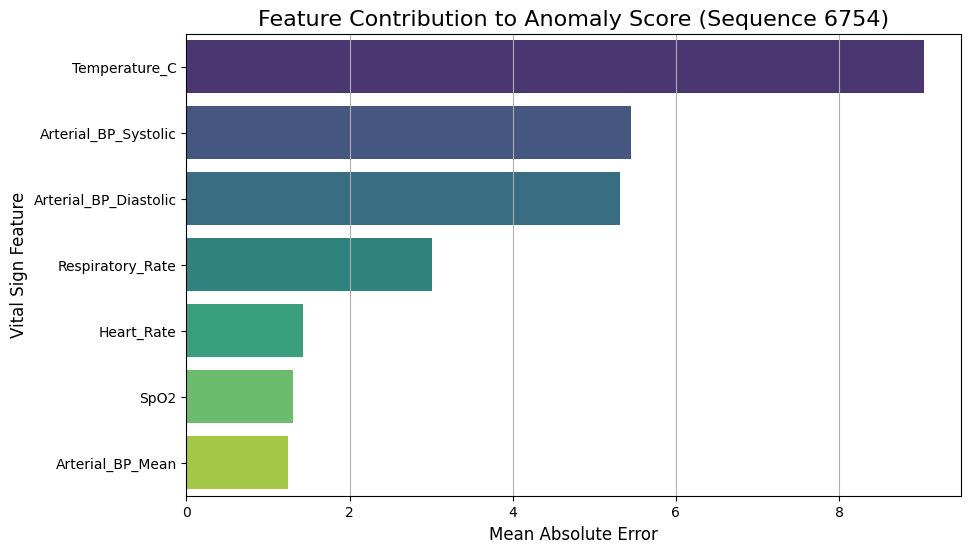


--- Interpretation ---


,Feature,Reconstruction_Error
6,Temperature_C,9.048661
2,Arterial_BP_Systolic,5.451050
0,Arterial_BP_Diastolic,5.314571
4,Respiratory_Rate,3.015629
3,Heart_Rate,1.431250
5,SpO2,1.312386
1,Arterial_BP_Mean,1.251029



The feature(s) with the highest reconstruction error are the primary drivers of this anomaly.


In [7]:
# ==============================================================================
# FINAL ANALYSIS: FEATURE-LEVEL RECONSTRUCTION ERROR (SHAP Alternative)
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assicuriamoci che i risultati dell'autoencoder esistano
if 'autoencoder' in locals() and 'X_test' in locals():
    # Usiamo lo stesso indice dell'anomalia che abbiamo visualizzato prima
    if 'top_anomaly_idx' in locals():

        print(f"--- Analyzing feature contribution for anomaly index: {top_anomaly_idx} ---")

        # Prendiamo la sequenza originale e quella ricostruita
        original_sequence = X_test[top_anomaly_idx]
        reconstructed_sequence = X_test_pred[top_anomaly_idx]

        # Calcoliamo l'errore assoluto medio per ogni feature lungo i passi temporali
        feature_errors = np.mean(np.abs(original_sequence - reconstructed_sequence), axis=0)

        # Creiamo un DataFrame per una facile visualizzazione
        error_df = pd.DataFrame({
            'Feature': vital_cols,
            'Reconstruction_Error': feature_errors
        }).sort_values(by='Reconstruction_Error', ascending=False)

        # Visualizziamo gli errori
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Reconstruction_Error', y='Feature', data=error_df, palette='viridis')
        plt.title(f'Feature Contribution to Anomaly Score (Sequence {top_anomaly_idx})', fontsize=16)
        plt.xlabel('Mean Absolute Error', fontsize=12)
        plt.ylabel('Vital Sign Feature', fontsize=12)
        plt.grid(axis='x')
        plt.show()

        print("\n--- Interpretation ---")
        display(error_df)
        print("\nThe feature(s) with the highest reconstruction error are the primary drivers of this anomaly.")

    else:
        print("No anomaly was previously identified to analyze.")
else:
    print("ERROR: Autoencoder results not found.")

--- Starting Synthetic Anomaly Detection Test ---
Selected a normal sequence (index 0) with a low reconstruction error of: 0.0006

-> Injected a synthetic SpO2 sensor fault into the normal sequence.
Reconstruction error on the faulty sequence: 0.1011
SUCCESS: The model correctly identified the synthetic fault with a much higher error.


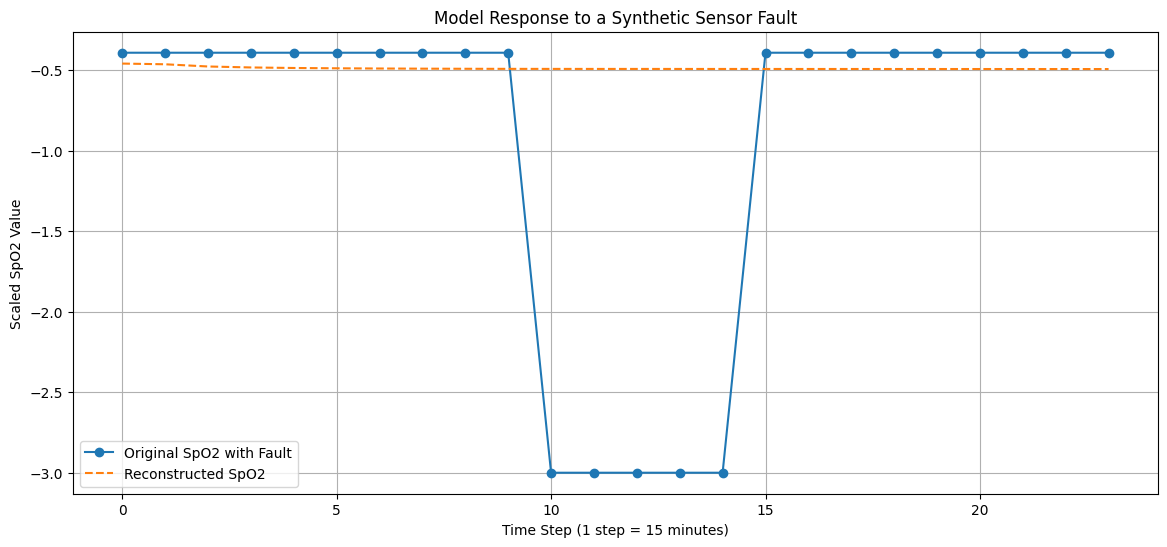

In [8]:
# ==============================================================================
# FINAL EXPERIMENT: DETECTING A SYNTHETIC SENSOR FAULT
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt

# Check if the required variables from previous steps exist
if 'autoencoder' in locals() and 'X_test' in locals() and 'test_mae_loss' in locals():
    print("--- Starting Synthetic Anomaly Detection Test ---")

    # 1. Find a "normal" sequence from the test set (with the lowest reconstruction error)
    normal_sequence_idx = np.argmin(test_mae_loss.mean(axis=1))
    original_normal_sequence = X_test[normal_sequence_idx]

    # Calculate its original low error
    original_normal_pred = autoencoder.predict(np.expand_dims(original_normal_sequence, axis=0), verbose=0)
    original_error = np.mean(np.abs(original_normal_pred - original_normal_sequence))
    print(f"Selected a normal sequence (index {normal_sequence_idx}) with a low reconstruction error of: {original_error:.4f}")

    # 2. Create a synthetic anomaly: a sensor fault
    # We take a copy of the normal sequence and alter it
    faulty_sequence = original_normal_sequence.copy()

    # The SpO2 feature is at index 5 in our 'vital_cols' list
    spo2_index = 5
    # Let's simulate the SpO2 sensor flat-lining at a very low value for 5 time steps
    faulty_sequence[10:15, spo2_index] = -3.0 # A very low value since data is scaled
    print("\n-> Injected a synthetic SpO2 sensor fault into the normal sequence.")

    # 3. Test the model on the faulty sequence
    faulty_sequence_reshaped = np.expand_dims(faulty_sequence, axis=0)
    reconstructed_faulty_sequence = autoencoder.predict(faulty_sequence_reshaped, verbose=0)

    # 4. Compare the reconstruction error
    faulty_error = np.mean(np.abs(reconstructed_faulty_sequence - faulty_sequence))
    print(f"Reconstruction error on the faulty sequence: {faulty_error:.4f}")
    if faulty_error > original_error * 2: # Check if the error increased significantly
        print("SUCCESS: The model correctly identified the synthetic fault with a much higher error.")

    # 5. Visualize the result
    plt.figure(figsize=(14, 6))
    plt.plot(faulty_sequence[:, spo2_index], label='Original SpO2 with Fault', marker='o')
    plt.plot(reconstructed_faulty_sequence[0, :, spo2_index], label='Reconstructed SpO2', linestyle='--')
    plt.title('Model Response to a Synthetic Sensor Fault')
    plt.xlabel('Time Step (1 step = 15 minutes)')
    plt.ylabel('Scaled SpO2 Value')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("ERROR: Autoencoder results not found. Please re-run the previous steps.")

In [9]:
# Save the trained Autoencoder model
autoencoder.save('/content/drive/MyDrive/mimic-iv-demo/lstm_autoencoder.keras')
print("LSTM Autoencoder model saved successfully.")

LSTM Autoencoder model saved successfully.


In [10]:
# ==========================================================
# SAVE CLINICAL TEST DATA (CORRECTED VARIABLE NAME)
# Run this cell once after the autoencoder training is complete
# ==========================================================
import numpy as np

# Check if the correct variable 'X_test' exists
if 'X_test' in locals():
    print("Saving clinical test sequences to file...")
    # We save the 'X_test' variable to a file named 'X_test_sequences.npy'
    # so the fusion notebook can find it.
    np.save('/content/drive/MyDrive/mimic-iv-demo/X_test_sequences.npy', X_test)
    print("✅ Clinical test sequences saved successfully.")
else:
    print("❌ ERROR: 'X_test' not found. Please ensure the autoencoder training cell has been run successfully.")

Saving clinical test sequences to file...
✅ Clinical test sequences saved successfully.
